# Introduction to the Modelling Process

In this part of the project, we build two baseline classification models to predict influenza vaccine response. Our dataset poses several challenges: it is imbalanced (unequal numbers of high and low responders), has many missing values, and contains features with complex non-linear relationships.

For this initial modeling step, we use Random Forest and XGBoost classifiers without any hyperparameter tuning or advanced feature engineering. This gives us a straightforward baseline to understand how capable these models are at predicting vaccine response "out of the box." Essentially, this helps us assess if these models are a good fit for our problem before moving on to more sophisticated approaches.

To tackle the problems posed by the data, we design the modeling process with the following key steps:
- **Data Preprocessing:** We started by preparing the raw data, which included aggregating multiple measurements and thoughtfully handling a large amount of missing information.

- **Model Selection:** We chose robust models—Random Forest and XGBoost—that are well-suited to the challenges we identified.

- **Cross-Validation:** To assess our models’ performance, we used stratified cross-validation, ensuring consistent class proportions across training and testing splits.

- **Evaluation:** We evaluated the models using various visual and quantitative methods, including cross-validation plots, confusion matrices, and ROC-AUC curves.

- **Model Interpretation:** Finally, we employed SHAP to gain insight into why our models made the predictions they did, adding interpretability to our results
---

# Step 1 - Importing Libraries

To build and evaluate our models, we imported:

- **`numpy`**: For numerical operations
- **`pandas`**: For data manipulation and analysis
- **`matplotlib.pyplot`**: For creating visualisations
- **`shap`**: For interpreting model predictions using SHAP values
- **`joblib.Parallel`, `joblib.delayed`**: For parallelising tasks to speed up computations

### Metrics and Evaluation
We also imported several metrics and evaluation tools from `sklearn.metrics`:
- **`accuracy_score`**: To measure overall prediction accuracy
- **`f1_score`**: To balance precision and recall, especially with imbalanced data
- **`confusion_matrix`**: To evaluate classification results in detail
- **`ConfusionMatrixDisplay`**: To visualise confusion matrices
- **`roc_curve`**: To build ROC curves for model evaluation
- **`roc_auc_score`**: To calculate the area under the ROC curve (AUC)
- **`log_loss`**: To evaluate the probability outputs of the model

### Model Validation and Preprocessing
- **`StratifiedKFold`**: For stratified cross-validation
- **`StandardScaler`**: For feature scaling
- **`enable_iterative_imputer`, `SimpleImputer`, `IterativeImputer`**: For handling missing values
- **`RandomForestClassifier`, `RandomForestRegressor`**: For building Random Forest models and imputation
- **`Pipeline`**: To streamline preprocessing and modelling steps
- **`xgboost.XGBClassifier`**: For gradient boosting classification


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss

# Step 2 - Loading the Dataset

For modeling, we load the cleaned FluPRINT dataset filtered and processed previously. This dataset contains all necessary immune cell measurements, vaccine response labels, and donor metadata.

In [2]:
# Define the path to the FluPRINT database CSV file
database = r"C:\Users\Dana\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\Fluprint_cleaned.csv"

# Read the CSV file
fluprint_filtered = pd.read_csv(database)

# Display the contents of the DataFrame
display(fluprint_filtered)

,donor_id,gender,race,visit_year,visit_age,vaccine,geo_mean,d_geo_mean,name,name_formatted,subset,units,data,vaccine_response,category
0,813,Female,Caucasian,2014,23.00,Fluzone,380.55,1.0,B cells,B_cells,CD14-CD33-/CD3-/CD19+CD20+,% of Parent,34.40,0.0,Immune Cell
1,813,Female,Caucasian,2014,23.00,Fluzone,380.55,1.0,basophils,basophils,CD123+HLADR-,% of Parent,1.45,0.0,Immune Cell
2,813,Female,Caucasian,2014,23.00,Fluzone,380.55,1.0,CD16+ monocytes,CD16_pos_monocytes,CD14+CD33+/CD16+,% of Parent,5.85,0.0,Immune Cell
3,813,Female,Caucasian,2014,23.00,Fluzone,380.55,1.0,CD16+CD14+ monocytes,CD16_pos_CD14_pos_monocytes,CD14+CD33+/CD14+CD16+,% of Parent,1.55,0.0,Immune Cell
4,813,Female,Caucasian,2014,23.00,Fluzone,380.55,1.0,CD16+CD14- monocytes,CD16_pos_CD14_neg_monocytes,CD14+CD33+/CD14-CD16+,% of Parent,4.46,0.0,Immune Cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62616,49,Male,Caucasian,2014,9.71,Flumist,269.09,1.0,TNFB,TNFB,TNFB,Z.log2,-0.65,0.0,Signaling Molecules
62617,49,Male,Caucasian,2014,9.71,Flumist,269.09,1.0,TRAIL,TRAIL,TRAIL,Z.log2,-0.63,0.0,Signaling Molecules
62618,49,Male,Caucasian,2014,9.71,Flumist,269.09,1.0,VCAM1,VCAM1,VCAM1,Z.log2,0.50,0.0,Signaling Molecules
62619,49,Male,Caucasian,2014,9.71,Flumist,269.09,1.0,VEGF,VEGF,VEGF,Z.log2,1.06,0.0,Signaling Molecules


# Step 3 - The Preprocessing: Getting Our Data Ready

Before we can feed the data into our machine learning models, it’s important to preprocess it properly. We transformed our initial raw data, which was in a *long* format with multiple rows per donor, into a *wide* format with a single row for each donor. This was done by aggregating the measurements by `name_formatted` (rather than using the "subset" column), where we calculated the median for each donor.

While the subset did contain very detailed information about each of the immune cells involved, which could have helped us understand what drives a high immune response, we opted for aggregation. If we had used the detailed subset, we would have encountered even more missing rows, potentially introducing more noise into the analysis. We previously experimented with this approach (data not shown) and seen a very high amount of missing data. Only about 100 variables had less than 95% missing data.

This granular approach would have provided a much more detailed view of the dataset, but given that some feature readings were recorded only once, it wasn’t a feasible option. Thus, we decided to proceed with the aggregated dataset to maintain a more robust and manageable analysis.

In [3]:
# Step 1: Aggregate duplicated measurements by donor and feature (mean)
agg_df = fluprint_filtered.groupby(["donor_id", "name_formatted"], as_index=False)["data"].median()

# Step 2: Pivot to wide format - donors as rows, features as columns
X_features = agg_df.pivot(index="donor_id", columns="name_formatted", values="data")

# Extract vaccine_response per donor
y = fluprint_filtered.groupby("donor_id")["vaccine_response"].first()

# Align y to X_features indices (donor_ids)
y = y.loc[X_features.index]

# Print shape of the pivoted data
print(f"Pivoted data shape: {X_features.shape}")

# Step 3: Calculate missing data fraction and drop high-missingness features
missing_fraction = X_features.isnull().mean()
keep_features = missing_fraction[missing_fraction <= 0.90].index
X_filtered = X_features[keep_features]

print(f"Original feature count: {X_features.shape[1]}")
print(f"Filtered feature count (<=90% missing): {X_filtered.shape[1]}")

Pivoted data shape: (292, 3283)
Original feature count: 3283
Filtered feature count (<=90% missing): 407


# 2.Model Pipelines

In this section, we implement **cross-validation** to assess the performance of different imputation strategies and model combinations (Random Forest and XGBoost). We use **StratifiedKFold** for cross-validation, ensuring that each fold maintains the proportion of classes in both the training and testing sets.

### 1. **StratifiedKFold Setup**
We begin by defining the number of folds for cross-validation:
Here, n_splits = 5 means we will divide the dataset into 5 folds. The data will be split so that the distribution of the target variable remains consistent across all folds, which is important when dealing with imbalanced datasets.

### 2. **Imputation**: 
We handle missing data by imputing missing values with a specific strategy:

- **`SimpleImputer(strategy='mean')`**: Fills missing values with the mean of the column.
- **`SimpleImputer(strategy='median')`**: Fills missing values with the median of the column.
- **`IterativeImputer`**: Uses multiple regression models to iteratively impute missing values (this is also referred to as MI).
- **`IterativeImputer(sample_posterior=True)`**: Similar to `IterativeImputer`, but includes a sample from the posterior distribution for more variability (known as PMM).
- **`IterativeImputer(estimator=RandomForestRegressor())`**: Uses a Random Forest Regressor as an estimator for missing value imputation (known as MissForest).

### 3. **Feature Scaling**: 
The `StandardScaler` is applied to standardise features, ensuring they all have a mean of 0 and a standard deviation of 1. This helps to put all features on the same scale, which is an extra step for us. Decision trees are not affected by non-standardised data, but it can be helpful if we ever decide to switch models.

### 4. **Classifier**:
- **`RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)`**: A random forest with 100 trees, using all CPU cores for parallelisation.
- **`XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1)`**: XGBoost with 100 trees, optimising for log loss and parallelisation.

The rest of the code is explained as comments 



In [4]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for each strategy, without class-imbalance handling ---
pipelines = {
    "mean_rf": Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()),
                         ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "mean_xgb": Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()),
                          ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))]),
    "median_rf": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()),
                           ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "median_xgb": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()),
                            ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))]),
    "mi_rf": Pipeline([("imputer", IterativeImputer(random_state=42, max_iter=10, initial_strategy="mean")), ("scaler", StandardScaler()),
                       ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "mi_xgb": Pipeline([("imputer", IterativeImputer(random_state=42, max_iter=10, initial_strategy="mean")), ("scaler", StandardScaler()),
                        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))]),
    "pmm_rf": Pipeline([("imputer", IterativeImputer(random_state=42, sample_posterior=True, max_iter=10, initial_strategy="mean")), ("scaler", StandardScaler()),
                        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "pmm_xgb": Pipeline([("imputer", IterativeImputer(random_state=42, sample_posterior=True, max_iter=10, initial_strategy="mean")), ("scaler", StandardScaler()),
                         ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))]),
    "missforest_rf": Pipeline([("imputer", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42), random_state=42, max_iter=10)), ("scaler", StandardScaler()),
                               ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "missforest_xgb": Pipeline([("imputer", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42), random_state=42, max_iter=10)), ("scaler", StandardScaler()),
                                ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))]),
}

# Dictionary to store results
results = {
    "mean": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "median": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "mi": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "pmm": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
    "missforest": {"rf_accuracies": [], "xgb_accuracies": [], "rf_f1_weighted": [], "xgb_f1_weighted": []},
}

# Variables to dynamically store the best model"s SHAP data
best_rf_f1_score = -1
best_rf_strategy = ""
best_xgb_f1_score = -1
best_xgb_strategy = ""
best_rf_shap_data = {"X_test": None, "rf_values": None}
best_xgb_shap_data = {"X_test": None, "xgb_values": None}


# Function to run the pipeline for a single fold
def run_fold(pipeline, X_train, X_test, y_train, y_test, is_last_fold, strategy_name, model_name, is_best_rf, is_best_xgb):
    # Fit the model pipeline to the training data
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and weighted F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    
    shap_data = None

    # Compute SHAP values for the best models in the last fold
    if is_last_fold and (is_best_rf or is_best_xgb):
        model = pipeline.named_steps["classifier"]
        preprocessed_X_test = pipeline[:-1].transform(X_test)
        
        if isinstance(model, RandomForestClassifier) and is_best_rf:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(preprocessed_X_test)
            shap_data = {"X_test": preprocessed_X_test, "rf_values": shap_values}
        elif isinstance(model, XGBClassifier) and is_best_xgb:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(preprocessed_X_test)
            shap_data = {"X_test": preprocessed_X_test, "xgb_values": shap_values}
    
    return accuracy, f1_weighted, shap_data



# Loop over each strategy and model in the pipelines
for strategy_key, pipeline in pipelines.items():
    strategy_name = strategy_key.split("_")[0]
    model_name = strategy_key.split("_")[1]
    
    # We will determine the best models dynamically, so these flags will be passed as False
    is_best_rf = False
    is_best_xgb = False
    
    print(f"\n--- Strategy: {strategy_name.upper()} with Model: {model_name.upper()} ---")

    # Parallelize cross-validation for each fold (makes running the code faster)
    fold_results = Parallel(n_jobs=-1)(
        delayed(run_fold)(
            pipeline,
            X_filtered.iloc[train_index],
            X_filtered.iloc[test_index],
            y.iloc[train_index],
            y.iloc[test_index],
            fold == n_splits - 1,
            strategy_name,
            model_name,
            is_best_rf,
            is_best_xgb
        )
        for fold, (train_index, test_index) in enumerate(skf.split(X_filtered, y))
    )

    # Extract accuracy and F1 scores from the results of each fold
    accuracies = [res[0] for res in fold_results]
    f1_scores = [res[1] for res in fold_results]
    
    # Store them, then calculate average performance metric and print them
    results[strategy_name][f"{model_name}_accuracies"] = accuracies
    results[strategy_name][f"{model_name}_f1_weighted"] = f1_scores
    
    avg_f1 = np.mean(f1_scores)
    avg_accuracy = np.mean(accuracies)
    std_f1 = np.std(f1_scores)
    std_accuracy = np.std(accuracies)
    
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average F1-weighted: {avg_f1:.4f} ± {std_f1:.4f}")
    
    # Check if this is the best performing model for its type so far
    if model_name == "rf" and avg_f1 > best_rf_f1_score:
        best_rf_f1_score = avg_f1
        best_rf_strategy = strategy_name
    elif model_name == "xgb" and avg_f1 > best_xgb_f1_score:
        best_xgb_f1_score = avg_f1
        best_xgb_strategy = strategy_name
    
    del fold_results

# Now, re-run the final fold for the best models to collect SHAP values
print(f"\n--- Re-running the final fold for the best RF and XGBoost models to collect SHAP values ---")

# Identify the pipelines for the best RF and XGBoost models
best_rf_pipeline_key = f"{best_rf_strategy}_rf"
best_rf_pipeline = pipelines[best_rf_pipeline_key]
best_xgb_pipeline_key = f"{best_xgb_strategy}_xgb"
best_xgb_pipeline = pipelines[best_xgb_pipeline_key]

# Get the data for the final fold
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# Run fold for best RF model
_, _, rf_shap_data = run_fold(best_rf_pipeline, X_train_final, X_test_final, y_train_final, y_test_final, True, best_rf_strategy, "rf", True, False)
if rf_shap_data:
    best_rf_shap_data = rf_shap_data

# Run fold for best XGBoost model
_, _, xgb_shap_data = run_fold(best_xgb_pipeline, X_train_final, X_test_final, y_train_final, y_test_final, True, best_xgb_strategy, "xgb", False, True)
if xgb_shap_data:
    best_xgb_shap_data = xgb_shap_data

print("\n" + "="*40)
print("--- Cross-Validation Summary (without Imbalance Handling) ---")
print("="*40)

for strategy, model_results in results.items():
    print(f"\n--- Imputation Method: {strategy.upper()} ---")
    print(f"  Random Forest Average Accuracy: {np.mean(model_results["rf_accuracies"]):.4f} ± {np.std(model_results["rf_accuracies"]):.4f}")
    print(f"  Random Forest Average F1-weighted: {np.mean(model_results["rf_f1_weighted"]):.4f} ± {np.std(model_results["rf_f1_weighted"]):.4f}")
    print(f"  XGBoost Average Accuracy: {np.mean(model_results["xgb_accuracies"]):.4f} ± {np.std(model_results["xgb_accuracies"]):.4f}")
    print(f"  XGBoost Average F1-weighted: {np.mean(model_results["xgb_f1_weighted"]):.4f} ± {np.std(model_results["xgb_f1_weighted"]):.4f}")


--- Strategy: MEAN with Model: RF ---
Average Accuracy: 0.6781 ± 0.0362
Average F1-weighted: 0.6397 ± 0.0337

--- Strategy: MEAN with Model: XGB ---
Average Accuracy: 0.6507 ± 0.0249
Average F1-weighted: 0.6368 ± 0.0250

--- Strategy: MEDIAN with Model: RF ---
Average Accuracy: 0.6542 ± 0.0386
Average F1-weighted: 0.6106 ± 0.0459

--- Strategy: MEDIAN with Model: XGB ---
Average Accuracy: 0.6611 ± 0.0292
Average F1-weighted: 0.6483 ± 0.0387

--- Strategy: MI with Model: RF ---
Average Accuracy: 0.6578 ± 0.0364
Average F1-weighted: 0.6315 ± 0.0427

--- Strategy: MI with Model: XGB ---
Average Accuracy: 0.6372 ± 0.0371
Average F1-weighted: 0.6247 ± 0.0312

--- Strategy: PMM with Model: RF ---
Average Accuracy: 0.6612 ± 0.0357
Average F1-weighted: 0.5895 ± 0.0348

--- Strategy: PMM with Model: XGB ---
Average Accuracy: 0.6473 ± 0.0155
Average F1-weighted: 0.6109 ± 0.0357

--- Strategy: MISSFOREST with Model: RF ---
Average Accuracy: 0.6473 ± 0.0344
Average F1-weighted: 0.5962 ± 0.0369

-


--- Generating Comparison Plots (Accuracy & F1-weighted) ---


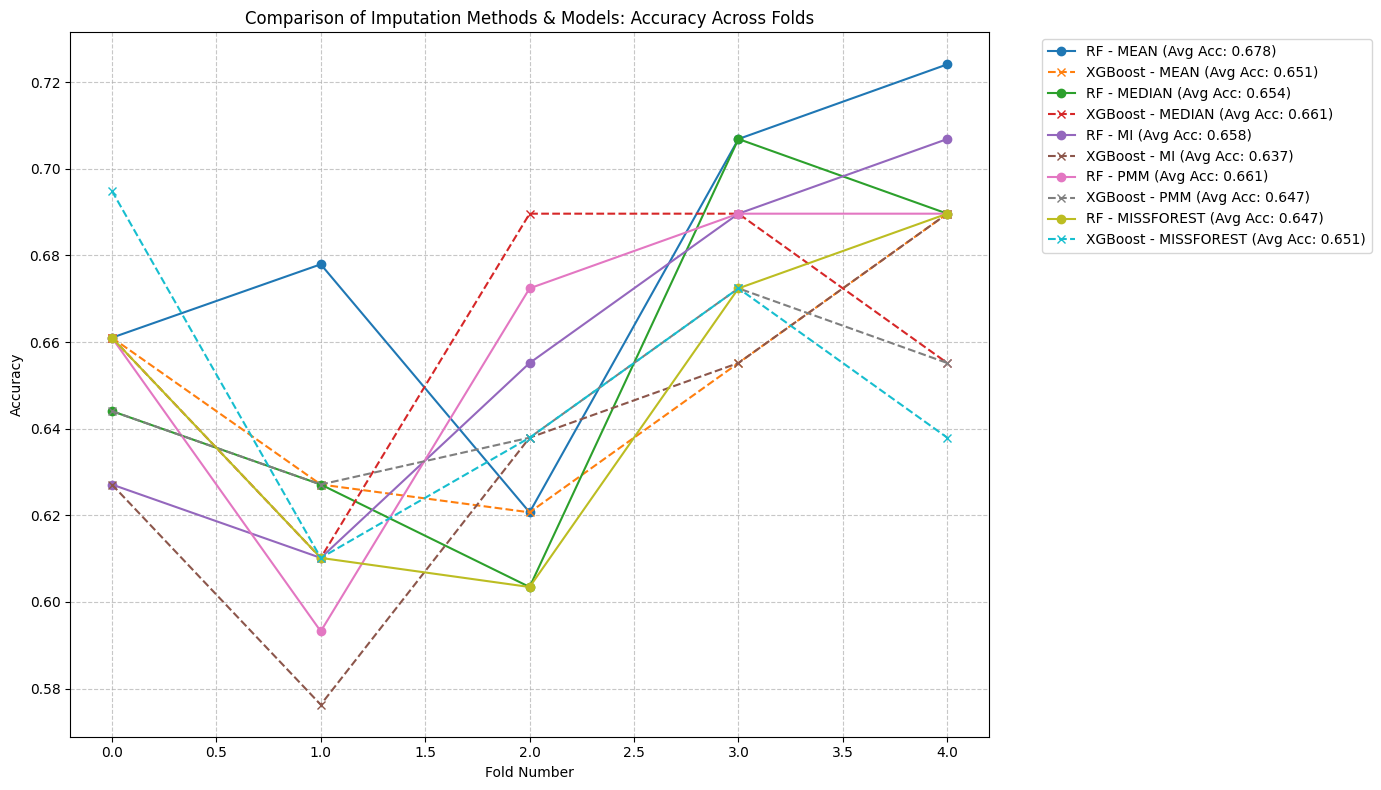

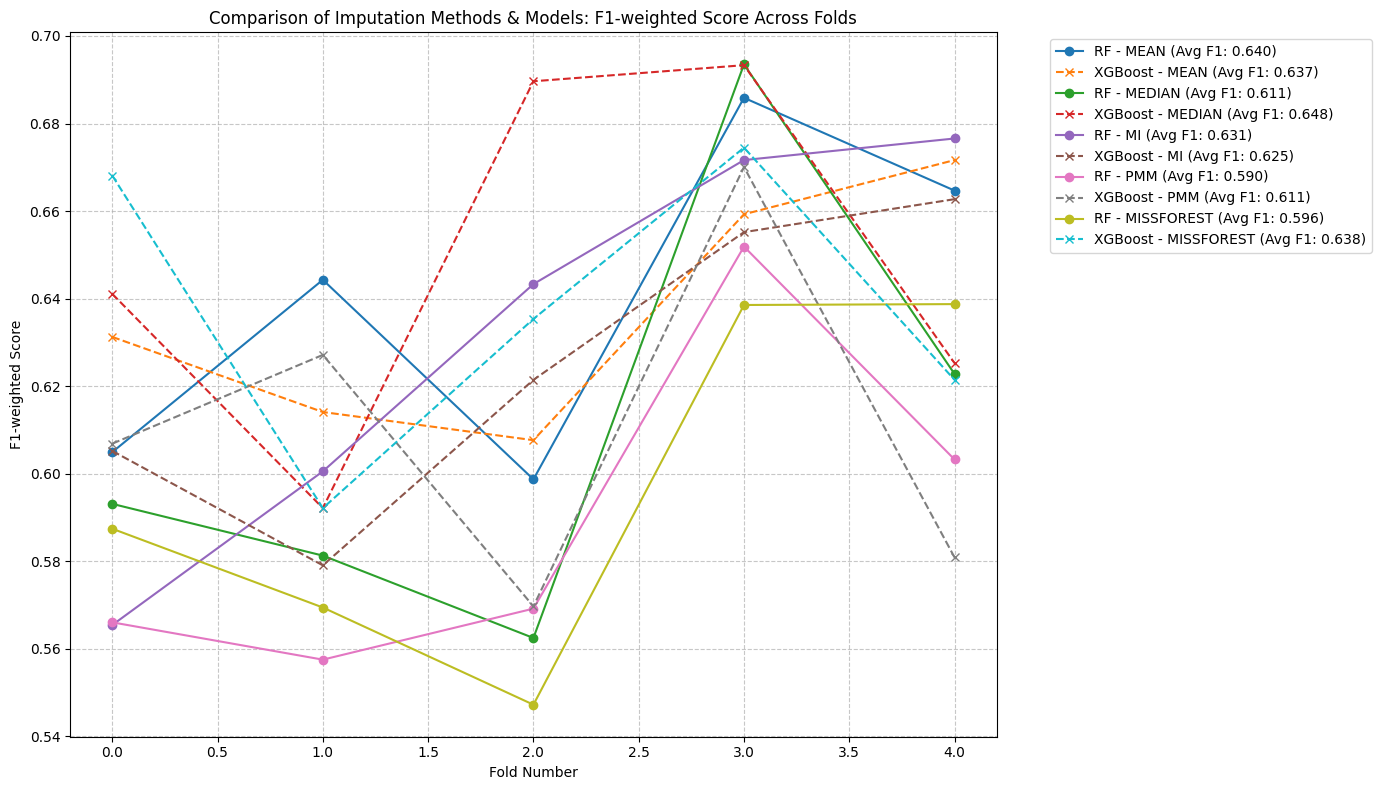


--- SHAP Plots for Best RF and XGBoost Models ---
Best RF: MEAN (F1: 0.6397) | Best XGBoost: MEDIAN (F1: 0.6483)

SHAP Summary Plot for Random Forest (MEAN Imputation):


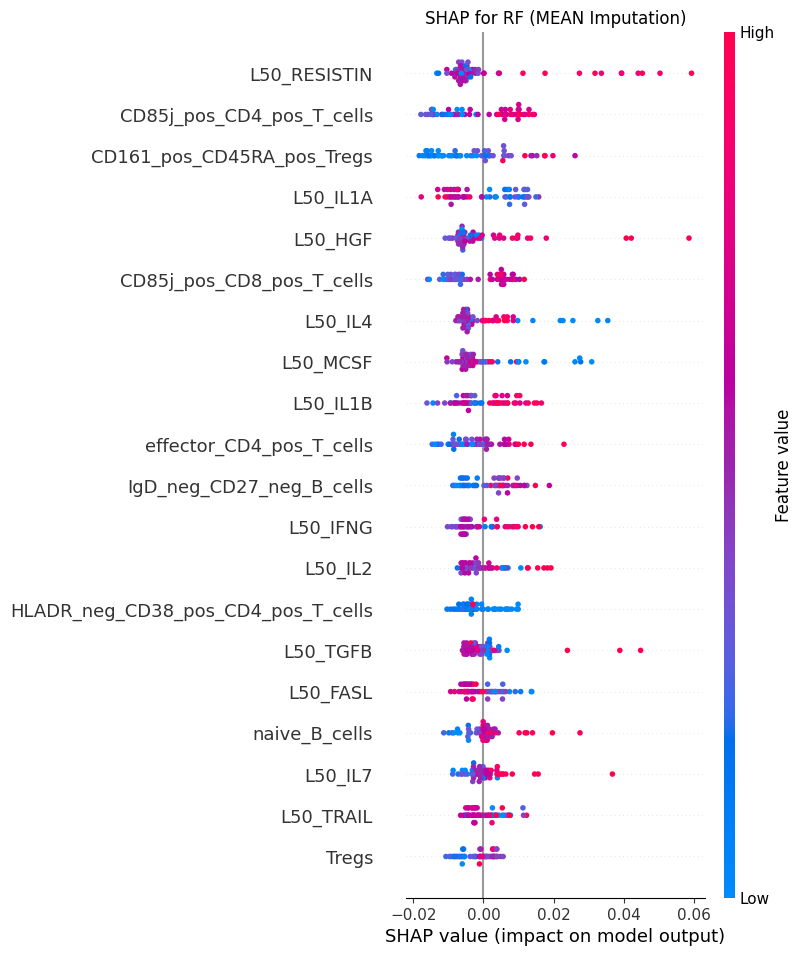


SHAP Summary Plot for XGBoost (MEDIAN Imputation):


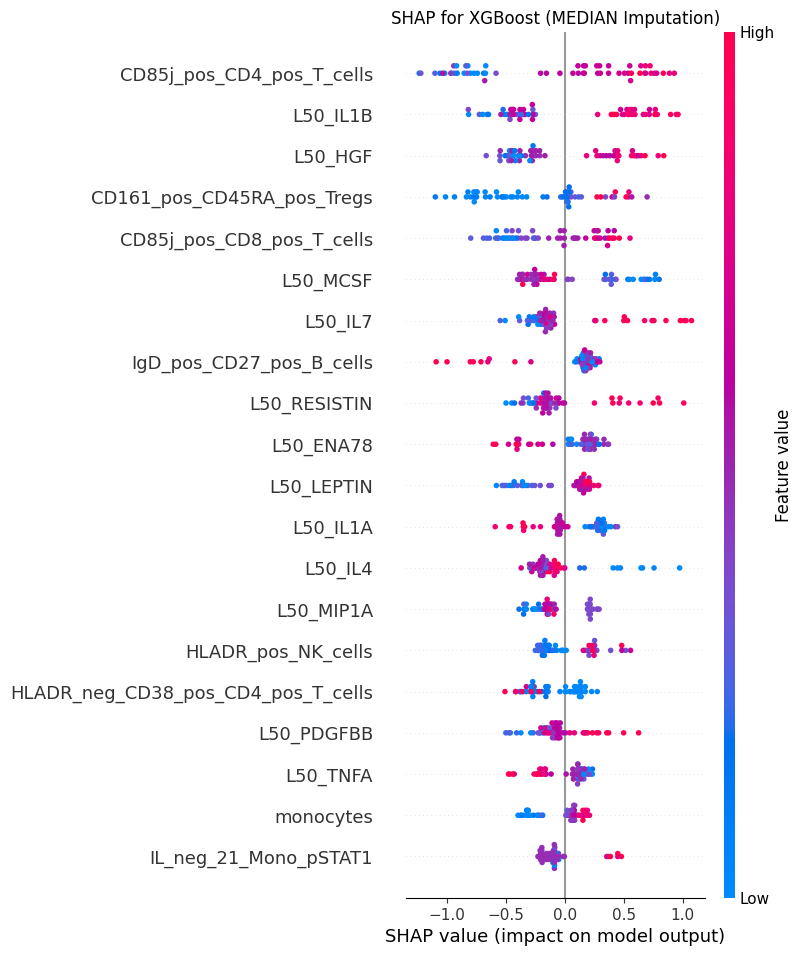

In [8]:
# --- Plotting ---
print("\n--- Generating Comparison Plots (Accuracy & F1-weighted) ---")

# Plot 1: Accuracy Comparison
plt.figure(figsize=(14, 8))
imputation_strategies = list(results.keys())
for method in imputation_strategies:
    plt.plot(results[method]['rf_accuracies'], marker='o', linestyle='-',
             label=f'RF - {method.upper()} (Avg Acc: {np.mean(results[method]["rf_accuracies"]):.3f})')
    plt.plot(results[method]['xgb_accuracies'], marker='x', linestyle='--',
             label=f'XGBoost - {method.upper()} (Avg Acc: {np.mean(results[method]["xgb_accuracies"]):.3f})')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Comparison of Imputation Methods & Models: Accuracy Across Folds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: F1-weighted Comparison
plt.figure(figsize=(14, 8))
for method in imputation_strategies:
    plt.plot(results[method]['rf_f1_weighted'], marker='o', linestyle='-',
             label=f'RF - {method.upper()} (Avg F1: {np.mean(results[method]["rf_f1_weighted"]):.3f})')
    plt.plot(results[method]['xgb_f1_weighted'], marker='x', linestyle='--',
             label=f'XGBoost - {method.upper()} (Avg F1: {np.mean(results[method]["xgb_f1_weighted"]):.3f})')
plt.xlabel('Fold Number')
plt.ylabel('F1-weighted Score')
plt.title('Comparison of Imputation Methods & Models: F1-weighted Score Across Folds')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- SHAP Plots ---
print("\n" + "="*40)
print(f"--- SHAP Plots for Best RF and XGBoost Models ---")
print(f"Best RF: {best_rf_strategy.upper()} (F1: {best_rf_f1_score:.4f}) | Best XGBoost: {best_xgb_strategy.upper()} (F1: {best_xgb_f1_score:.4f})")
print("="*40)


original_feature_names = X_filtered.columns

# RF SHAP plot
if best_rf_shap_data['rf_values'] is not None:
    print(f"\nSHAP Summary Plot for Random Forest ({best_rf_strategy.upper()} Imputation):")
    shap_values_rf_for_plot = best_rf_shap_data['rf_values'][:, :, 1]
    
    # Pass the original feature names directly
    shap.summary_plot(shap_values_rf_for_plot, best_rf_shap_data['X_test'], show=False, feature_names=original_feature_names)
    plt.title(f"SHAP for RF ({best_rf_strategy.upper()} Imputation)")
    plt.show()
else:
    print(f"SHAP values for the best RF model ({best_rf_strategy.upper()} imputation) were not collected.")

# XGB SHAP plot
if best_xgb_shap_data['xgb_values'] is not None:
    print(f"\nSHAP Summary Plot for XGBoost ({best_xgb_strategy.upper()} Imputation):")
    shap_values_xgb = best_xgb_shap_data['xgb_values']
    if isinstance(shap_values_xgb, list) and len(shap_values_xgb) > 1:
        shap_values_xgb_for_plot = shap_values_xgb[1]
    elif isinstance(shap_values_xgb, np.ndarray) and shap_values_xgb.ndim == 3:
        shap_values_xgb_for_plot = shap_values_xgb[:, :, 1]
    else:
        shap_values_xgb_for_plot = shap_values_xgb
    
    # Pass the original feature names directly
    shap.summary_plot(shap_values_xgb_for_plot, best_xgb_shap_data['X_test'], show=False, feature_names=original_feature_names)
    plt.title(f"SHAP for XGBoost ({best_xgb_strategy.upper()} Imputation)")
    plt.show()
else:
    print(f"SHAP values for the best XGBoost model ({best_xgb_strategy.upper()} imputation) were not collected.")

## Step 4: Confusion Matrices for Best Mean-Imputation Models

To better understand the classification performance, we visualise **confusion matrices** for the best-performing Random Forest and XGBoost models using mean/median imputation.

### What do the confusion matrices show?

- The counts of **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**
- Insight into the types of classification errors made
- Whether the model tends to **favor one class over the other**.

### Why mean/median imputation?

- Mean and Median imputation was selected here as a straightforward baseline method to focus on evaluating classifier behavior.
- The confusion matrices correspond to the **last fold** of cross-validation.
- Nothing else changes here compared to the other pipeline

--- Training and Evaluating Best Random Forest (Mean Imputation) ---


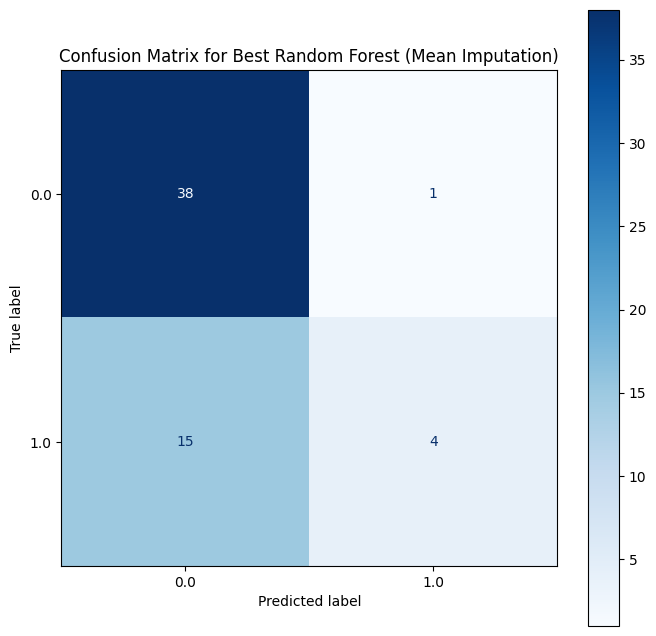



--- Training and Evaluating Best XGBoost (Median Imputation) ---


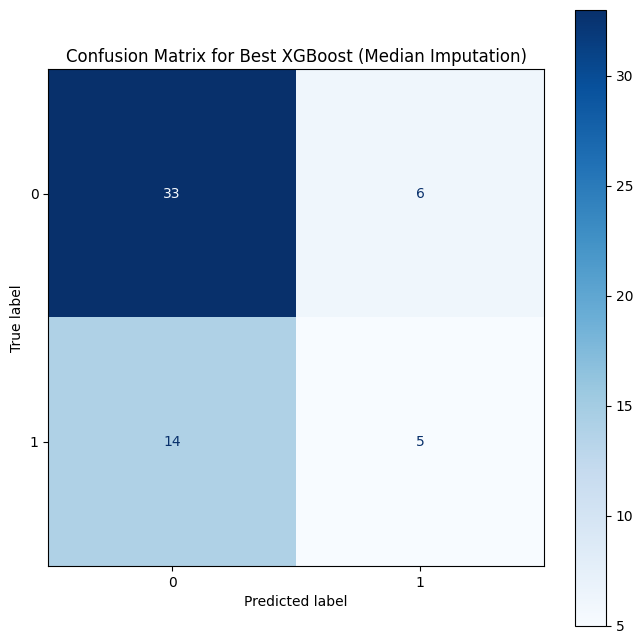

In [ ]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for the Best Models ---
# Based on the original analysis, the best RF used MEAN imputation and the best XGBoost used MEDIAN imputation.
best_pipelines = {
    "best_rf": Pipeline([
        ("imputer", SimpleImputer(strategy="mean"), "scaler", StandardScaler(), "classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]),
    "best_xgb": Pipeline([
        ("imputer", SimpleImputer(strategy="median"), "scaler", StandardScaler(),"classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the Best RF Model ---
print("--- Training and Evaluating Best Random Forest (Mean Imputation) ---")
best_rf_pipeline = best_pipelines["best_rf"]
best_rf_pipeline.fit(X_train_final, y_train_final)
y_pred_rf = best_rf_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for RF
cm_rf = confusion_matrix(y_test_final, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Best Random Forest (Mean Imputation)")
plt.show()

print("\n")

# --- Train and Evaluate the Best XGBoost Model ---
print("--- Training and Evaluating Best XGBoost (Median Imputation) ---")
best_xgb_pipeline = best_pipelines["best_xgb"]
best_xgb_pipeline.fit(X_train_final, y_train_final)
y_pred_xgb = best_xgb_pipeline.predict(X_test_final)

# Create and plot the Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test_final, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=best_xgb_pipeline.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Best XGBoost (Median Imputation)")
plt.show()

## ROC-AUC

Same format as before but in this case we want to calculate the: 
- **AUC**: A summary measure of model performance. An AUC of 0.5 indicates no discrimination (random predictions), while an AUC closer to 1.0 indicates a better model.

- **ROC**: A plot that shows the trade-off between sensitivity (true positive rate) and specificity (false positive rate) at different classification thresholds.

## Step 5: ROC Curve and Area Under the Curve (AUC) Evaluation

### What is ROC?

A **Receiver Operating Characteristic (ROC) curve** is used to evaluate the performance of a classifier. It plots the **True Positive Rate (TPR or Sensitivity)** against the **False Positive Rate (FPR or 1 - Specificity)** at different threshold settings.

- **True Positive Rate (TPR)**: The fraction of true positives correctly identified by the model.  
- **False Positive Rate (FPR)**: The fraction of true negatives incorrectly classified as positive.

### What is AUC?

The **Area Under the ROC Curve (AUC)** summarises the ROC curve as a single number between 0 and 1:

- An AUC of **0.5** indicates performance no better than random guessing.
- The higher the AUC values the better model is at distinguishing between clases.

Unlike accuracy, which depends on a fixed classification threshold, ROC and AUC provide a **threshold-independent** evaluation of performance. This is especially useful for imbalanced classes, which is the case for FluPRINT data.

### Pipeline

- We compute ROC curves and AUC scores for the best mean-imputation Random Forest and XGBoost models on the final cross-validation fold.
- This evaluation complements other metrics by providing a more detailed view of the models’ diagnostic ability over various thresholds.
- ROC curves are plotted to visually compare the two classifiers.

---


--- Evaluating Best Random Forest (Mean Imputation) ---
Random Forest AUC: 0.6869
--- Evaluating Best XGBoost (Median Imputation) ---
XGBoost AUC: 0.6586


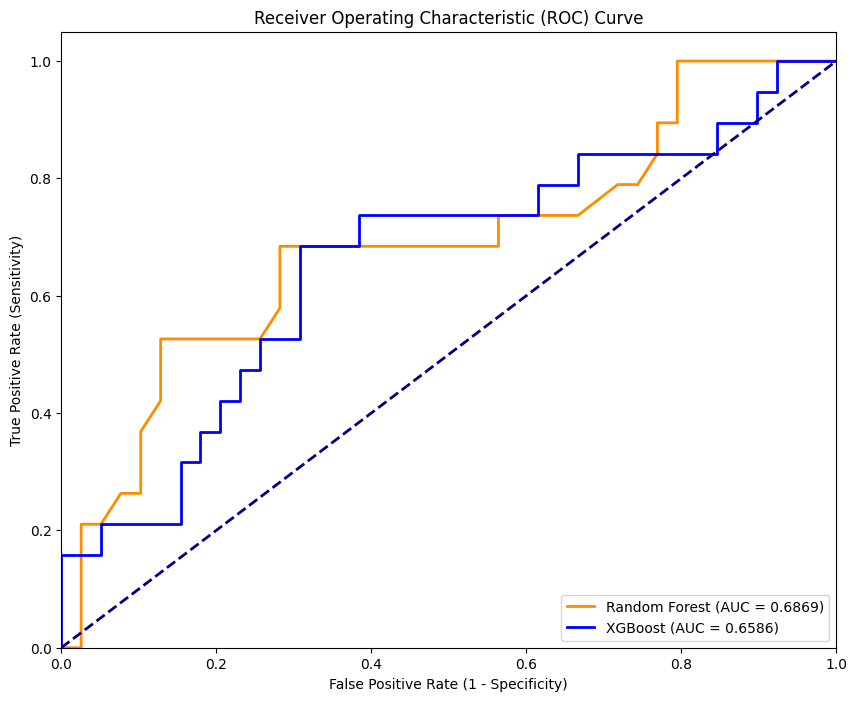

In [6]:
# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for the Best Models ---
# The best RF used MEAN imputation, and the best XGBoost used MEDIAN.
best_pipelines = {
    "best_rf": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "best_xgb": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}

# Get the data for the final fold (last fold of the cross-validation)
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Train and Evaluate the Best RF Model ---
print("--- Evaluating Best Random Forest (Mean Imputation) ---")
best_rf_pipeline = best_pipelines["best_rf"]
best_rf_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_rf = best_rf_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_proba_rf)
auc_rf = roc_auc_score(y_test_final, y_proba_rf)
print(f"Random Forest AUC: {auc_rf:.4f}")

# --- Train and Evaluate the Best XGBoost Model ---
print("--- Evaluating Best XGBoost (Median Imputation) ---")
best_xgb_pipeline = best_pipelines["best_xgb"]
best_xgb_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for the positive class
y_proba_xgb = best_xgb_pipeline.predict_proba(X_test_final)[:, 1]

# Calculate ROC curve and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_final, y_proba_xgb)
auc_xgb = roc_auc_score(y_test_final, y_proba_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

# --- Plotting the ROC Curves ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2, label=f"Random Forest (AUC = {auc_rf:.4f})")
plt.plot(fpr_xgb, tpr_xgb, color="blue", lw=2, label=f"XGBoost (AUC = {auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


## Log-Loss

Same logic as before, but in this instance we calculate the **Log Loss** which is a measure of how well the predicted probabilities match the actual labels. A lower log loss indicates that the model’s predicted probabilities are closer to the true labels. It's particularly useful in classification problems where we want to measure the model's certainty about its predictions.


In [7]:
# --- Define the Cross-Validation Strategy ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Define Pipelines for the Best Models ---
# Again it is the same as before
best_pipelines = {
    "best_rf": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "best_xgb": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("classifier", XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, n_jobs=-1))
    ])
}

# --- Get the data for the final cross-validation fold ---
final_fold_indices = list(skf.split(X_filtered, y))[-1]
train_index_final, test_index_final = final_fold_indices
X_train_final, X_test_final = X_filtered.iloc[train_index_final], X_filtered.iloc[test_index_final]
y_train_final, y_test_final = y.iloc[train_index_final], y.iloc[test_index_final]

# --- Calculate Log Loss for the Best Random Forest Model ---
print("--- Calculating Log Loss for Random Forest (Mean Imputation) ---")
best_rf_pipeline = best_pipelines["best_rf"]
best_rf_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for all classes
y_proba_rf = best_rf_pipeline.predict_proba(X_test_final)
logloss_rf = log_loss(y_test_final, y_proba_rf)
print(f"Random Forest Log Loss: {logloss_rf:.4f}")

# --- Calculate Log Loss for the Best XGBoost Model ---
print("\n--- Calculating Log Loss for XGBoost (Median Imputation) ---")
best_xgb_pipeline = best_pipelines["best_xgb"]
best_xgb_pipeline.fit(X_train_final, y_train_final)
# Predict probabilities for all classes
y_proba_xgb = best_xgb_pipeline.predict_proba(X_test_final)
logloss_xgb = log_loss(y_test_final, y_proba_xgb)
print(f"XGBoost Log Loss: {logloss_xgb:.4f}")

--- Calculating Log Loss for Random Forest (Mean Imputation) ---
Random Forest Log Loss: 0.6032

--- Calculating Log Loss for XGBoost (Median Imputation) ---
XGBoost Log Loss: 0.8087
